In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle

from skimage.transform import resize
from skimage.io import imread
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray, rgba2rgb
from skimage.io import imread_collection
from math import floor, ceil

from sklearn.manifold import MDS, Isomap
from sklearn.cluster import SpectralClustering

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from scipy.sparse import csgraph
from scipy.linalg import eigvalsh

import polyphase as phase
from polyphase.parallel import get_distance_matrix

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
tab_colors = list(mcolors.TABLEAU_COLORS)

In [3]:
SAVE_FIGS= False

## Set up a pipeline for data analysis

In [4]:
def touchup3d(ax):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.zaxis._axinfo['juggled'] = (1,2,0)

In [5]:
# 1. Distance function
def get_grayscale_ssim(file0, file1):
    """Given two file names, return SSIM distance
    
    file0, file1 : Image file address
    
    returns : SSIM similarity score 
    """
    img0 = imread(file0)
    img1 = imread(file1)
    img0 = resize(img0, (64,64))
    img1 = resize(img1, (64,64))
    img0= rgb2gray(rgba2rgb(img0))
    img1= rgb2gray(rgba2rgb(img1))
    d = ssim(img0, img1)
    
    return 1-d

# 4. dimensionality reduction

def _get_explained_variance(Dm,emb):
    explained_variance = []
    for dim in [1,2,3]:
        Dy = squareform(pdist(emb[:,:dim]))
        explained_variance.append(pearsonr(Dm.flatten(), 
                                           Dy.flatten())[0])
    
    return explained_variance
    
def perform_isomap(M):
    embedding = Isomap(n_components=3,n_neighbors=5, 
                       metric='precomputed')
    embedding.fit(M)
    Dm = embedding.dist_matrix_
    emb_isomap = embedding.embedding_
    explained_variance = _get_explained_variance(Dm,emb_isomap)
        
    return emb_isomap, explained_variance

def perform_MDS(M):
    embedding = MDS(n_components=3,  dissimilarity='precomputed', 
                    metric=True, random_state=0)
    emb = embedding.fit_transform(M)
    explained_variance = _get_explained_variance(M,emb)
    
    return emb,explained_variance

# 5. Perform clustering
def cluster_embedding(X, emb, n_clusters=4):
    """Given a low dimensional embedding, cluster them and return labels,
    eigen values of graph Laplacian
    
    X : affinity matrix of images
    emb : embedding (array of shape (num_points, dimension))
    n_clusters : Number of clusters expected
    
    returns:
        higdim_labels : Labels for the clustering performed on images addinity matrix
        lowdim_labels : Labels for the points in `emb` based on clustering
        eigen_values. : Eigen values of the graph Laplacian
    """
    clustering = SpectralClustering(n_clusters=n_clusters,assign_labels="discretize",
                                    random_state=0, affinity='precomputed')
    
    highdim_labels = clustering.fit_predict(X)
    
    D = squareform(pdist(emb, 'euclidean'))
    delta = 0.01
    A = np.exp(- D ** 2 / (2. * delta ** 2))
    lowdim_labels = clustering.fit_predict(A)
    
    return highdim_labels, lowdim_labels

class Pipeline:
    def __init__(self,M):
        self.M = M
        delta = M.std()
        self.X = np.exp(- M ** 2 / (2. * delta ** 2))
        
    def compute(self, drmethod='isomap', n_clusters=4):
        if drmethod=='isomap':
            self.emb, self.explained_variance = perform_isomap(self.M)
        elif drmethod=='mds':
            self.emb, self.explained_variance = perform_MDS(self.M)
            
        self.highdim_labels, self.lowdim_labels = cluster_embedding(self.X, self.emb,
                                                                        n_clusters=n_clusters)
        
        return
    
    def plot_embedding(self, use_highdim=True, ax = None):
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = plt.gcf()
            
        if use_highdim:
            _labels = self.highdim_labels
        else:
            _labels = self.lowdim_labels    
            
        if hasattr(self, 'emb'):
            all_labels = np.unique(_labels)
            for i, label in enumerate(all_labels) :
                ax.scatter(self.emb[_labels==label,0], 
                           self.emb[_labels==label,1], 
                           label=str(label), color=tab_colors[i])
            ax.legend()                                                                                            
            ax.set_xlabel(r"Coordinate 1 ({:.2f}%)".format(self.explained_variance[0]*100))
            ax.set_ylabel(r"Coordinate 2 ({:.2f}%)".format((self.explained_variance[1]
                                                             -self.explained_variance[0])*100))
            return ax, fig
        else:
            RuntimeError('You need to call .compute(*,**) before .plot_embedding(*,**)')
            
    def show_clusters(self,files, use_highdim=True):
        
        if use_highdim:
            _labels = self.highdim_labels
        else:
            _labels = self.lowdim_labels
            
        ic = imread_collection(files)
        num_images = len(ic)

        # Two pairs of `nrows, ncols` are possible
        k = (num_images * 12)**0.5
        r1 = max(1, floor(k / 4))
        r2 = ceil(k / 4)
        c1 = ceil(num_images / r1)
        c2 = ceil(num_images / r2)

        # Select the one which is closer to 4:3
        if abs(r1 / c1 - 0.75) < abs(r2 / c2 - 0.75):
            nrows, ncols = r1, c1
        else:
            nrows, ncols = r2, c2

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows,ncols))
        ax = np.asarray(axes).ravel()
        all_labels = np.unique(_labels)
        axis_id = 0
        for label in all_labels:
            label_files = np.where(_labels==label)[0]
            print('Cardinality of cluster {} is {}'.format(label, len(label_files)))
            for n in label_files:
                img = plt.imread(files.replace('*',str(n)))
                ax[axis_id].imshow(img)
                ax[axis_id].axis('off')
                ax[axis_id].set_title('{}'.format(label))
                axis_id += 1
        for i in range(axis_id,int(nrows*ncols)):
            ax[i].axis('off')
        
        return fig        

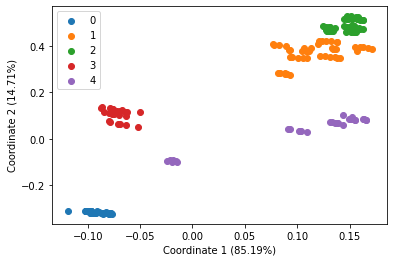

Cardinality of cluster 0 is 144
Cardinality of cluster 1 is 48
Cardinality of cluster 2 is 48
Cardinality of cluster 3 is 24
Cardinality of cluster 4 is 30


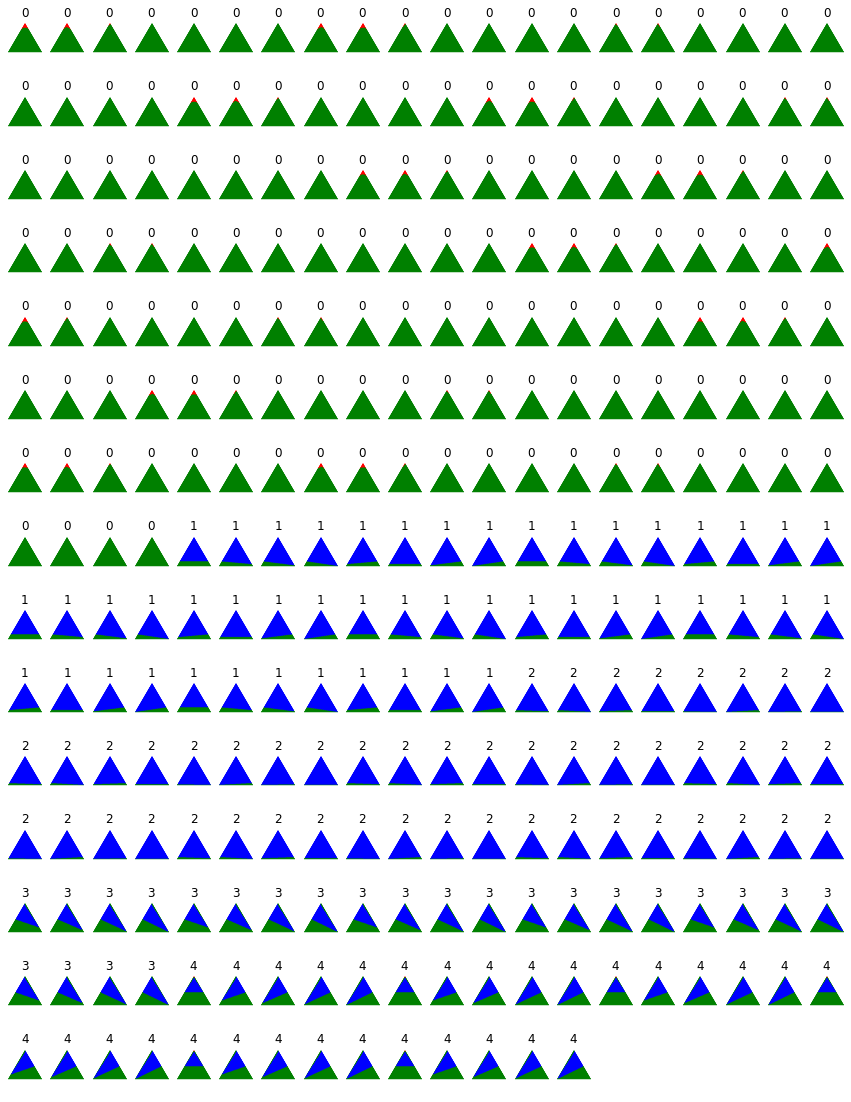

In [20]:
# Apply the workflow to synthetic data set of chispace exploration
# see expts/explore_chispace.py for generation of PDs
dirname = '../expts/data/hamming/chispace'
distmats = dirname + '/distance.pkl'
#distmats = '../expts/data/final/gray_chispace_dimred_mp10.pkl'
with open(distmats, 'rb') as handle:
    out = pickle.load(handle)
    
USE_HIGHDIM = True    
M = out['M']
workflow = Pipeline(M)
workflow.compute(drmethod='mds',n_clusters=5)
workflow.plot_embedding(use_highdim=USE_HIGHDIM)
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_Synthetic_MDS.png', 
                dpi=400, bbox_inches='tight')
else:
    plt.show()

fig = workflow.show_clusters(dirname+'/pds/*.png',use_highdim=USE_HIGHDIM)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_Synthetic_Clusters.png', 
                dpi=400, bbox_inches='tight', pad_inches = 0)
else:
    plt.show()

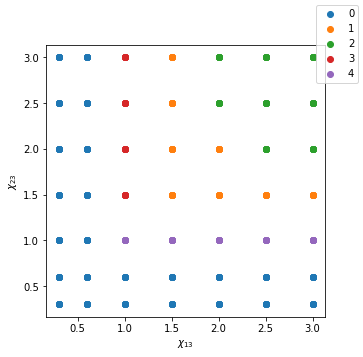

In [26]:
df=out['df']
fig, ax = plt.subplots(figsize=(5,5))
labels = workflow.highdim_labels
unique_labels = np.unique(labels)
for ul in unique_labels:
    ax.scatter(df[labels==ul]['chi13'],df[labels==ul]['chi23'],
               label=str(ul))
    
ax.set_xlabel(r'$\chi_{13}$')
ax.set_ylabel(r'$\chi_{23}$')
fig.legend(loc='upper right')
plt.show()

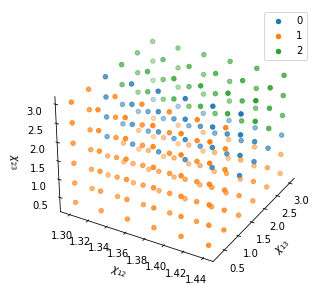

In [18]:
df=out['df']

fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection':'3d'})
labels = workflow.highdim_labels
unique_labels = np.unique(labels)
for ul in unique_labels:
    ax.scatter(df[labels==ul]['chi12'], df[labels==ul]['chi13'],
              df[labels==ul]['chi23'], label=str(ul))
        
ax.set_xlabel(r'$\chi_{12}$')
ax.set_ylabel(r'$\chi_{13}$')
ax.set_zlabel(r'$\chi_{23}$')
ax.legend()
touchup3d(ax)
    
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_Synthetic_DesignSpace.png', 
                dpi=400, bbox_inches='tight')
else:
    plt.show()

In [11]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
#                                    mode='markers')])
fig = go.Figure(data=[go.Scatter3d(
    x=df['chi12'], y=df['chi13'], z=df['chi23'],
    mode='markers',
    marker=dict(size=5,color=labels,colorscale='viridis',
                colorbar=dict(thickness=10), opacity=0.7),
    showlegend=False)])
scene = dict(camera= dict(eye=dict(x=1.15, y=1.15, z=0.8)),
             aspectmode='cube', xaxis = dict(title='chi 12'), 
             yaxis = dict(title='chi 13'),
             zaxis = dict(title='chi 23'))
fig['layout']['scene'].update(scene)
fig.write_html('../figures/notebooks/1.html')

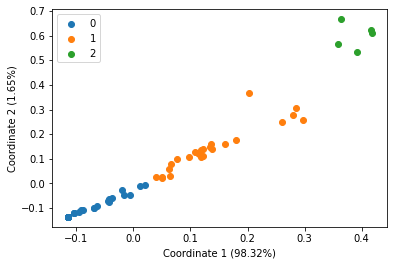

Cardinality of cluster 0 is 56
Cardinality of cluster 1 is 25
Cardinality of cluster 2 is 5


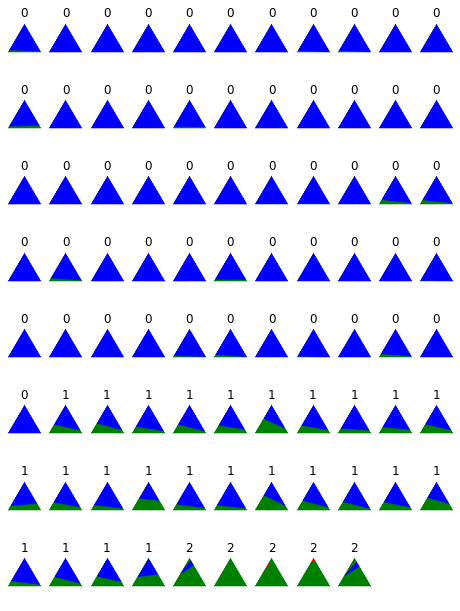

In [12]:
# apply the workflow to PM6-Y6-Solvents data set
dirname = '../expts/data/hamming/pm6y6'
distmats = dirname + '/distance.pkl'

#distmats = '../expts/data/final/MSE_distance_PM6_Y6.pkl'
with open(distmats, 'rb') as handle:
    out = pickle.load(handle)

USE_HIGHDIM = True
sys_df = out['df'].reset_index(drop=True)
M = out['M']
workflow = Pipeline(M)
workflow.compute(drmethod='mds', n_clusters=3)
workflow.plot_embedding(use_highdim=USE_HIGHDIM)
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_PM6_Y6_MDS.png', 
                dpi=400, bbox_inches='tight')
else:
    plt.show()

fig = workflow.show_clusters(dirname+'/pds/*.png',use_highdim=USE_HIGHDIM)
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_PM6_Y6_Clusters.png', 
                dpi=400, bbox_inches='tight')
else:
    plt.show()

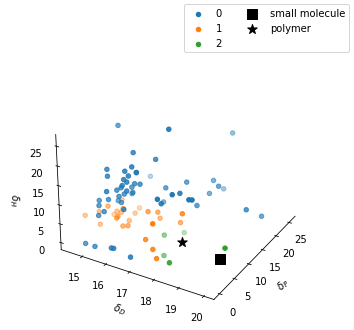

In [13]:
df = out['df']
deltas = np.asarray(df['delta_solv'].to_list())
sm = df['delta_SM'][0]
polymer = df['delta_polymer'][0]
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection':'3d'})
labels = workflow.highdim_labels
unique_labels = np.unique(labels)
for ul in unique_labels:
    ax.scatter(deltas[labels==ul,0], deltas[labels==ul,1],
              deltas[labels==ul,2], label=str(ul))
    
ax.scatter(sm[0], sm[1], sm[2], 
           marker='s',s=100,color='k',label='small molecule')
ax.scatter(polymer[0], polymer[1], polymer[2],
           marker='*',s=100,color='k',label='polymer') 
    
ax.set_xlabel(r'$\delta_{D}$')
ax.set_ylabel(r'$\delta_{P}$')
ax.set_zlabel(r'$\delta_{H}$')

fig.legend(ncol=2)
touchup3d(ax)
    
if SAVE_FIGS:
    plt.savefig('../figures/final/result2_PM6_Y6_DesignSpace.png', 
                dpi=400, bbox_inches='tight')
else:
    plt.show()